<a href="https://colab.research.google.com/github/OsirisEscaL/Parkinson_Project/blob/main/KNeighborsClassifier_Parkinson_HeredetaryAtaxias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector, SelectFromModel, RFE
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
ds = pd.read_csv('Parkinson_HeredetaryAtaxias.csv') # Cambiar dataset
ds = ds.drop(['Unnamed: 0'], axis=1)
X = ds.iloc[:, 0:-1].values
y = ds.iloc[:, -1].values

rng = np.random.default_rng(seed=42)
random = rng.integers(10000, size=50)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()

In [4]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(scaled_X, y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['SVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_base = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.729429,0.487567,0.841881,0.752201,0.487567,0.9588,0.016333,0.014116,0.017287,0.009368,0.007061,0.017287,0.016812,0.03082


Oversampling

In [5]:
methods = [
    ("Random Over Sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ("ADASYN", ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)),
    ("BorderlineSMOTE", BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("SVMSMOTE", SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("KMeansSMOTE", KMeansSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2, cluster_balance_threshold=0.01))
]

In [6]:
results = {}
results_raw = {}

for method_name, method in methods:
    sample_x, sample_y = method.fit_resample(scaled_X, y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for num in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=num)
        for train_index, test_index in stratified_kfold.split(sample_x,sample_y):
            X_train, X_test = sample_x[train_index], sample_x[test_index]
            y_train, y_test = sample_y[train_index], sample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[method_name] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[method_name] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_over_ds = pd.DataFrame(results_raw)
results_raw_over_ds.to_csv('Results_Raw_Oversampling_KNeighborsClassifier.csv')

results_over_ds = pd.DataFrame(results).T
results_over_ds.to_csv('Results_Oversampling_KNeighborsClassifier.csv')
results_over_ds

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
Random Over Sampler,0.796982,0.019265,0.796165,0.019374,0.803790,0.027647,0.801636,0.025590,0.792327,0.039866,0.796404,0.017187,0.796982,0.019265
SMOTE,0.715582,0.018657,0.715403,0.018545,0.881368,0.033647,0.507636,0.030589,0.923527,0.024351,0.631177,0.026933,0.715582,0.018657
ADASYN,0.698248,0.023048,0.706000,0.022534,0.877454,0.051994,0.467345,0.035722,0.929152,0.034107,0.593631,0.034996,0.698248,0.023048
BorderlineSMOTE,0.698527,0.016283,0.698061,0.016474,0.832254,0.029683,0.505709,0.028670,0.891345,0.020038,0.615680,0.026285,0.698527,0.016283
SVMSMOTE,0.730688,0.019636,0.712222,0.019532,0.849709,0.028989,0.629091,0.030287,0.832286,0.029949,0.712324,0.022750,0.730688,0.019636
KMeansSMOTE,0.748655,0.019329,0.750173,0.019245,0.898102,0.031591,0.564655,0.036502,0.932655,0.021380,0.680033,0.031143,0.748655,0.019329


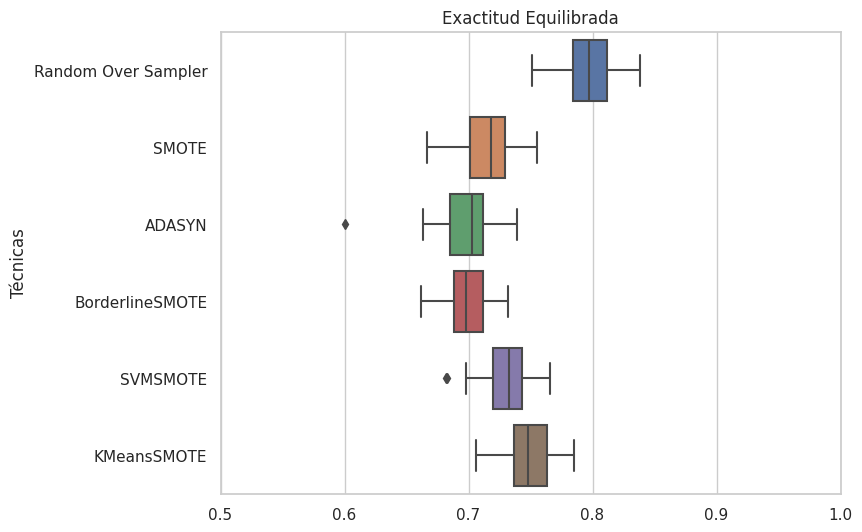

In [7]:
balanced_accuracy = pd.DataFrame(results_raw_over_ds.loc['Balanced_Accuracy'])
modelos = balanced_accuracy.index

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=balanced_accuracy['Balanced_Accuracy'], orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.5, 1)
plt.ylabel('Técnicas')
plt.gca().set_yticklabels(modelos)
plt.savefig('Boxplot_Oversampling_KNeighborsClassifier.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
samplers = ['Random Over Sampler', 'SMOTE', 'ADASYN', 'BorderlineSMOTE',
            'SVMSMOTE', 'KMeansSMOTE']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = results_raw_over_ds.loc['Balanced_Accuracy', sample1]
  for sample2 in samplers:
    val2 = results_raw_over_ds.loc['Balanced_Accuracy', sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_Oversampling_KNeighborsClassifier.csv')
comparison

statistic   p_value  \
Random Over Sampler Random Over Sampler    1250.0       1.0   
                    SMOTE                  2498.0       0.0   
                    ADASYN                 2500.0       0.0   
                    BorderlineSMOTE        2500.0       0.0   
                    SVMSMOTE               2485.0       0.0   
                    KMeansSMOTE            2395.0       0.0   
SMOTE               SMOTE                  1250.0       1.0   
                    ADASYN                 1783.0  0.000121   
                    BorderlineSMOTE        1888.5  0.000005   
ADASYN              ADASYN                 1250.0       1.0   
                    BorderlineSMOTE        1323.5  0.614764   
BorderlineSMOTE     ADASYN                 1176.5  0.614764   
                    BorderlineSMOTE        1250.0       1.0   
SVMSMOTE            SMOTE                  1787.0  0.000108   
                    ADASYN                 2195.0       0.0   
                    BorderlineSMOTE        2233.0       0.0   
                    SVMSMOTE               1250.0       1.0   
KMeansSMOTE         SMOTE                  2230.0       0.0   
                    ADASYN                 2412.0       0.0   
                    BorderlineSMOTE        2444.5       0.0   
                    SVMSMOTE               1832.0   0.00003   
                    KMeansSMOTE            1250.0       1.0   

                                                                                   greater  
Random Over Sampler Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          La primera muestra es significativamente mayor...  
SMOTE               SMOTE                No hay evidencia suficiente para afirmar que l...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
ADASYN              ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
BorderlineSMOTE     ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
SVMSMOTE            SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             No hay evidencia suficiente para afirmar que l...  
KMeansSMOTE         SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          No hay evidencia suficiente para afirmar que l...

In [9]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42) # Cambiar dependiendo cual fue mejor
oversample_X, oversample_y = oversampler.fit_resample(scaled_X, y)

In [10]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(oversample_X,oversample_y):
        X_train, X_test = oversample_X[train_index], oversample_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['SVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_over = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.796165,0.796982,0.796404,0.80379,0.796982,0.801636,0.792327,0.019374,0.019265,0.017187,0.027647,0.019265,0.02559,0.039866


In [11]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print(greater)

La primera muestra es significativamente mayor que la segunda.


Feature Selection

In [12]:
ds_X = ds.iloc[:, 0:-1]
features = ds_X.shape[1]

In [13]:
# SelectKBest
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectKBest(score_func=f_classif, k=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_selectK_ds = pd.DataFrame(results_raw)
results_raw_selectK_ds.to_csv('Results_Raw_SelectKBest_KNeighborsClassifier.csv')

results_selectK_ds = pd.DataFrame(results).T
number_of_features = results_selectK_ds.index + 1
results_selectK_ds.insert(0, 'Number_Features', number_of_features)
results_selectK_ds = results_selectK_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_selectK_ds.to_csv('Results_SelectKBest_KNeighborsClassifier.csv')
results_selectK_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
6,7,0.819600,0.017675,0.819446,0.017829,0.884186,0.026578,0.746873,0.024922,0.892327,0.029087,0.802291,0.018750,0.819600,0.017675
3,4,0.808909,0.019940,0.808667,0.020047,0.857925,0.024200,0.752400,0.025344,0.865418,0.028546,0.795324,0.020876,0.808909,0.019940
2,3,0.807818,0.021034,0.807853,0.020829,0.876680,0.033202,0.728618,0.018705,0.887018,0.040842,0.788592,0.017753,0.807818,0.021034
4,5,0.807418,0.018018,0.807143,0.018224,0.859049,0.027465,0.746800,0.017537,0.868036,0.031144,0.792594,0.017470,0.807418,0.018018
17,18,0.805745,0.019182,0.805160,0.019116,0.882872,0.039277,0.717455,0.023346,0.894036,0.038125,0.782741,0.018693,0.805745,0.019182


In [14]:
best_number_K = 7 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_K = SelectKBest(score_func=f_classif, k=best_number_K)
new_X_K = selector_K.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_K.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectKBest:")
print(selected_feature_names)

Características seleccionadas usando SelectKBest:
Index(['Freq_100_AP_Der', 'Sym_AP_Der', 'RMS_ML_Izq', 'Freq_50_VER_Izq',
       'Freq_75_VER_Izq', 'Freq_90_VER_Izq', 'Freq_100_VER_Izq'],
      dtype='object')


In [15]:
# Sequential Feature Selector
results = {}
results_raw = {}

for num in range(1, features):
    selector = SequentialFeatureSelector(model, n_features_to_select=num, direction='forward', cv=5, scoring='balanced_accuracy')
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_sequential_ds = pd.DataFrame(results_raw)
results_raw_sequential_ds.to_csv('Results_Raw_Sequential_KNeighborsClassifier.csv')

results_sequential_ds = pd.DataFrame(results).T
number_of_features = results_sequential_ds.index + 1
results_sequential_ds.insert(0, 'Number_Features', number_of_features)
results_sequential_ds = results_sequential_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_sequential_ds.to_csv('Results_Sequential_KNeighborsClassifier.csv')
results_sequential_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
8,9,0.885418,0.019038,0.885359,0.018833,0.951156,0.018790,0.818509,0.023683,0.952327,0.026048,0.874023,0.020047,0.885418,0.019038
12,13,0.874127,0.018559,0.874078,0.018429,0.949838,0.028105,0.794400,0.026692,0.953855,0.029013,0.858770,0.020814,0.874127,0.018559
13,14,0.857036,0.021211,0.856788,0.021403,0.952586,0.032863,0.760582,0.028800,0.953491,0.035121,0.836309,0.023964,0.857036,0.021211
9,10,0.856982,0.019078,0.857074,0.019160,0.942748,0.023369,0.766764,0.025754,0.947200,0.029016,0.838730,0.021104,0.856982,0.019078
14,15,0.855673,0.020783,0.855281,0.020829,0.934604,0.032630,0.774909,0.027615,0.936436,0.033804,0.838184,0.022524,0.855673,0.020783


In [16]:
best_number_Q = 9 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_Q = SequentialFeatureSelector(model, n_features_to_select=best_number_Q, direction='forward', cv=5, scoring='balanced_accuracy')
new_X_Q = selector_Q.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_Q.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SequentialFeatureSelector:")
print(selected_feature_names)

Características seleccionadas usando SequentialFeatureSelector:
Index(['Freq_90_VER_Der', 'Freq_100_VER_Der', 'Freq_75_ML_Der',
       'Freq_90_AP_Der', 'Sym_VER_Der', 'Stride_Reg_AP_Der', 'Freq_90_VER_Izq',
       'Freq_90_AP_Izq', 'Freq_100_AP_Izq'],
      dtype='object')


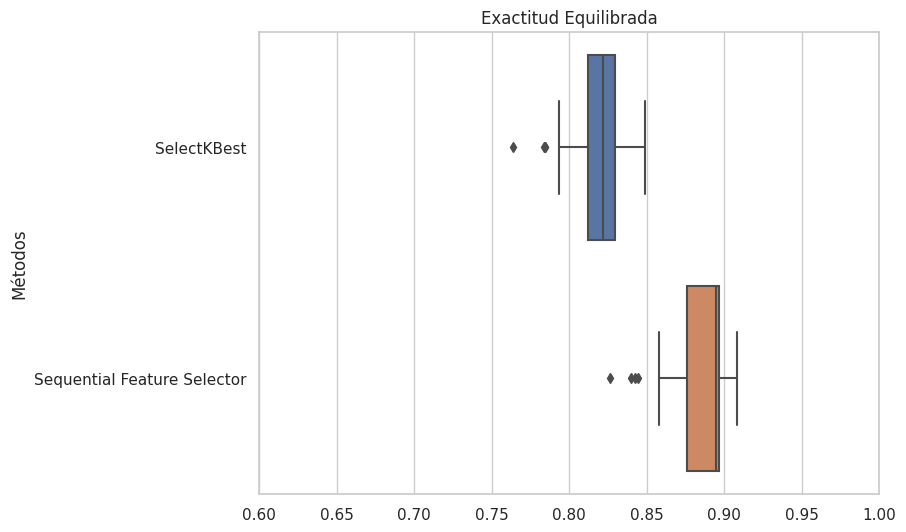

In [17]:
raw_SelectKBest = results_raw_selectK_ds.iloc[0, best_number_K-1]
raw_Sequential = results_raw_sequential_ds.iloc[0, best_number_Q-1]

raw_SelectKBest = pd.Series(raw_SelectKBest, name='SelectKBest')
raw_Sequential = pd.Series(raw_Sequential, name='Sequential Feature Selector')

FeaturesSelectors = pd.concat([raw_SelectKBest, raw_Sequential], axis=1)

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=FeaturesSelectors, orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.6, 1)
plt.ylabel('Métodos')
plt.savefig('Boxplot_FeatureSelection_KNeighborsClassifier.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
samplers = ['SelectKBest', 'Sequential Feature Selector']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = FeaturesSelectors.loc[:, sample1]
  for sample2 in samplers:
    val2 = FeaturesSelectors.loc[:, sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_FeaturesSelection_KNeighborsClassifier.csv')
comparison

statistic p_value  \
SelectKBest                 SelectKBest                    1250.0     1.0   
Sequential Feature Selector SelectKBest                    2467.5     0.0   
                            Sequential Feature Selector    1250.0     1.0   

                                                                                                   greater  
SelectKBest                 SelectKBest                  No hay evidencia suficiente para afirmar que l...  
Sequential Feature Selector SelectKBest                  La primera muestra es significativamente mayor...  
                            Sequential Feature Selector  No hay evidencia suficiente para afirmar que l...

SelectFromModel y RFE  no son directamente aplicable a algoritmos como SVC (Support Vector Classifier), GaussianNB (Naive Bayes Gaussiano) y KNeighborsClassifier cuando se utilizan en su forma estándar. La razón principal es que estos algoritmos no proporcionan directamente medidas de importancia de características (como los coeficientes en modelos lineales) que RFE utiliza para seleccionar y eliminar características de forma iterativa.

Para entenderlo mejor:

SVC (Support Vector Classifier): Los clasificadores SVM no tienen un concepto claro de importancia de características como lo hacen los modelos lineales. Los vectores de soporte y los hiperplanos de separación se determinan en función de las distancias y relaciones entre los puntos de datos en un espacio dimensional más alto. No hay coeficientes de características que puedas eliminar directamente.

GaussianNB (Naive Bayes Gaussiano): El clasificador Naive Bayes Gaussiano asume independencia entre las características y modela la distribución de las características utilizando estadísticas como la media y la varianza. No proporciona coeficientes de características que puedan utilizarse en RFE.

KNeighborsClassifier: KNeighborsClassifier es un algoritmo basado en instancias que se basa en comparaciones de distancia entre puntos de datos en el espacio de características. No tiene coeficientes de características que se puedan eliminar como en modelos lineales.

In [19]:
best_number = 9 # Cambiar dependiendo cual fue mejor
selector = SequentialFeatureSelector(model, n_features_to_select=best_number, direction='forward', cv=5, scoring='balanced_accuracy')
new_X = selector.fit_transform(oversample_X, oversample_y)

In [20]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['SVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_select = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.885359,0.885418,0.874023,0.951156,0.885418,0.818509,0.952327,0.018833,0.019038,0.020047,0.01879,0.019038,0.023683,0.026048


In [21]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print(greater)

La primera muestra es significativamente mayor que la segunda.


Hyperparameter Tunning

In [22]:
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=50,  scoring='balanced_accuracy')
grid_search.fit(new_X, oversample_y)

print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [23]:
model_hyper = KNeighborsClassifier(algorithm='auto', n_neighbors=3, p=1, weights='distance')

In [24]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model_hyper.fit(X_train, y_train)
        y_pred = model_hyper.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['SVC'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_hyper = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.893489,0.893909,0.880362,0.98097,0.893909,0.807891,0.979927,0.014413,0.014571,0.017256,0.02009,0.014571,0.027859,0.021031


In [25]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print(greater)

La primera muestra es significativamente mayor que la segunda.


Resultados y Curva ROC

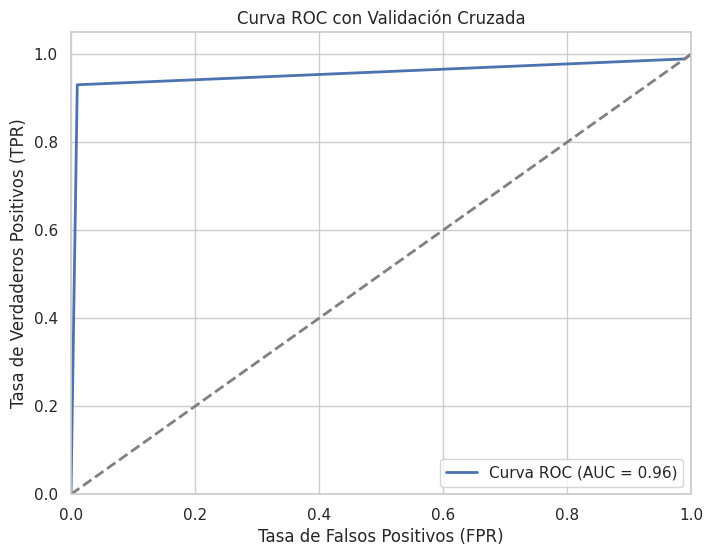

In [26]:
model_best = KNeighborsClassifier(algorithm='auto', n_neighbors=3, p=1, weights='distance') #Cambie para colocar el parametro probability

cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_index, test_index in cv.split(new_X, oversample_y):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = oversample_y[train_index], oversample_y[test_index]
    model_best.fit(X_train, y_train)
    y_pred_prob = model_best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

mean_tpr = np.mean(tprs, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Validación Cruzada')
plt.legend(loc='lower right')
plt.savefig('ROCCurve_KNeighborsClassifier.png', dpi=300, bbox_inches='tight')
plt.show()